# Update on Aviation Trends

The dataset used for this update is from [Aviation Stack](https://aviationstack.com/documentation). We used their API layer to extract arrivals and departures from BEY. We plan on validating this data with aviation data from OAG. The data has already been validated with a dataset from FlightRadar for the 16th of August 2024. The numbers on both datasets align. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Define a function to get a range of dates for the desirable date range

In [83]:
from datetime import datetime, timedelta
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days) + 1):
        yield (start_date + timedelta(n)).strftime("%Y-%m-%d")

# Define the start and end dates
start_date = datetime(2024, 6, 7)
end_date = datetime(2024, 6, 9)

In [91]:
# Define empty dataset to concat all the arrivals and departures
#departures = pd.DataFrame()

In [100]:
# # run the API to collect arrivals and departures
# import requests
# import urllib3
# from tqdm import tqdm

# # Suppress only the InsecureRequestWarning from urllib3
# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# # arr_iata_values = ['LOS', 'KWI', 'SHJ']
# # arr_iata_values = ','.join(arr_iata_values)

# #for one_day in tqdm(daterange(start_date, end_date)):
# params = {
#   'access_key': '12925396bddce38222e47eed53e76e6c',
#   #'dep_iata': 'BEY',
#   'arr_iata': 'BEY',
#   'limit':'100',
#   #'offset':'100',
#   'flight_date':'2024-04-30'
# }

# api_result = requests.get('https://api.aviationstack.com/v1/flights', params, verify=False)

# api_response = api_result.json()

# df = pd.DataFrame(api_response['data'])

# departures = pd.concat([departures,df])

In [75]:
# #arrivals.to_csv('../../data/aviation/aviationstack_bey_25082024_15082024_arr.csv')
# arrivals.to_csv('../../data/aviation/aviationstack_bey_26082024_01012024_arr.csv')

Functions to clean the database and explode columns

In [3]:
import ast

def safe_literal_eval(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return value
    return value

def explode(flights):
    flights['arrival'] = flights['arrival'].apply(safe_literal_eval)
    flights['departure'] = flights['departure'].apply(safe_literal_eval)
    
    fr1 = pd.json_normalize(flights['arrival']).add_suffix('_arr')
    fr2 = pd.json_normalize(flights['departure']).add_suffix('_dep')

    flights_exploded = pd.concat([flights.drop(columns=['arrival', 'departure']), fr1, fr2], axis=1)

    return flights_exploded


In [4]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, FixedTicker, HoverTool, CustomJS, Label, Span
from bokeh.palettes import Spectral6

def get_area_plot(df, title, source_text, acled_events_daily, reindex_freq='D', events={}):

    complete_date_range = pd.date_range(start=df['flight_date'].min(), end=df['flight_date'].max(), freq=reindex_freq)
    # Pivot the data to have flight_status as columns
    df_pivot = df.pivot_table(index='flight_date', columns='flight_status', values='iata_arr', aggfunc='sum')
    df_reindexed = df_pivot.reindex(complete_date_range).fillna(0)
    df_reindexed = df_reindexed.reset_index().rename(columns={'index': 'flight_date'})
    

    df['total_flights'] = df.groupby('flight_date')['iata_arr'].transform('sum')
    max_flight = df['total_flights'].max() + 50

    # Create a ColumnDataSource
    source = ColumnDataSource(df_reindexed)

    # Create a Bokeh figure
    p = figure(x_axis_type='datetime', height=600, width=800, title=title,
            toolbar_location=None, tools="", x_axis_label='Flight Date', y_axis_label='Nr Flights')

    # Create a stacked area plot using varea_stack
    status_list = list(df['flight_status'].unique())
    colors = Spectral6[:len(status_list)]  # Adjust the color palette to the number of flight statuses


    p.varea_stack(stackers=status_list, x='flight_date', color=colors, source=source, legend_label=status_list)
    p.line(x=acled_events_daily['event_date'], y=acled_events_daily['nrEvents'], line_width=2, line_color='black', legend_label='Number of Conflict Events w/o Protests')


    # Customize the plot
    p.y_range.start = 0
    p.y_range.end = max_flight

    # Format x-axis to show only the first day of each month
    p.xaxis.formatter = DatetimeTickFormatter(
        months="%b %Y",
        days="%d %b %Y"
    )

    # Limit the number of ticks by using FixedTicker
    date_range = pd.date_range(start=df['flight_date'].min(), end=df['flight_date'].max(), freq='W')
    ticks = [pd.to_datetime(date).timestamp() * 1000 for date in date_range]

    #complete_date_range = pd.date_range(start=df['flight_date'].min(), end=df['flight_date'].max())

    # Only keep a few ticks for clarity
    p.xaxis.ticker = FixedTicker(ticks=ticks[::2])  # Adjust the slicing (e.g., [::2], [::3]) for more or fewer ticks

    # Rotate x-axis labels for better readability
    p.xaxis.major_label_orientation = 1.2

    # Enable clickable legend
    p.legend.click_policy = "mute"

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [("Flight Date", "@flight_date{%F}"), ("Status", "$name"), ("Value", "@$name")]
    hover.formatters = {'@flight_date': 'datetime'}

    #p.legend.title = 'Flight Status'
    p.legend.location = 'top_left'
    p.legend.orientation = 'horizontal'

    source_label = Label(x=0, y=0, x_units='screen', y_units='screen',
                        text=source_text, 
                        text_font_size='10pt', text_color='gray')

    # Add the label to the plot
    p.add_layout(source_label, 'below')

    for event_date, event_desc in events.items():
        # Convert the event_date string to a datetime object
        event_date_dt = pd.to_datetime(event_date)
        
        # Create a Span object (vertical line)
        vline = Span(location=event_date_dt.timestamp() * 1000, dimension='height', line_color='grey', line_width=1, line_dash='dashed')
        p.add_layout(vline)
        
        # Add a label near the vertical line
        label = Label(x=event_date_dt.timestamp() * 1000, y=df[df['flight_date']==event_date]['total_flights'].iloc[0]+150, y_units='screen', text=event_desc, text_color='grey', text_align='left', text_font_size="9pt")
        p.add_layout(label)

    return p
    # Show the plot
    #show(p)

In [5]:
departures = pd.concat([pd.read_csv('../../data/aviation/aviationstack_bey_14082024_01012024_dep.csv'), 
                        pd.read_csv('../../data/aviation/aviationstack_bey_25082024_15082024_dep.csv'),
                        pd.read_csv('../../data/aviation/aviationstack_bey_25082024_01012024_dep2.csv')])
departures.drop(columns='Unnamed: 0', inplace=True)
departures.reset_index(drop=True, inplace=True)

In [6]:
departures_exploded = explode(departures)

In [7]:
import pandas as pd

df = departures
# Assuming df is your DataFrame and 'flight_date' is the column with the dates
df['flight_date'] = pd.to_datetime(df['flight_date'])  # Ensure 'flight_date' is in datetime format

# Generate the complete date range from the minimum to the maximum date
complete_date_range = pd.date_range(start=df['flight_date'].min(), end=df['flight_date'].max())

# Find missing dates by comparing the complete date range with the dates in the DataFrame
missing_dates = complete_date_range.difference(df['flight_date'])

if missing_dates.empty:
    print("All dates are present.")
else:
    print(f"The following dates are not available in the data. The reasons are unknown.: {missing_dates}")


The following dates are not available in the data. The reasons are unknown.: DatetimeIndex(['2024-01-29', '2024-01-30', '2024-04-29', '2024-04-30',
               '2024-06-07', '2024-06-08', '2024-06-09'],
              dtype='datetime64[ns]', freq=None)


## Analysing Number of Departures from Beirut International Airport in 2024

In [8]:
beginning = departures['flight_date'].min()
end = departures['flight_date'].max()
print(f'Data is available from {beginning} to {end}')

Data is available from 2024-01-01 00:00:00 to 2024-08-25 00:00:00


Conduct a duplication check for flights. If the flight is taking off from the same place, to the same place at the same time and has two entries, it is a duplicate flight

In [9]:
before = departures_exploded.shape[0]
print(f'There were {before} flights before duplication check')
# check for duplicate flights i.e., flights scheduled to take off at the exact same time from the same place to the same destination
departures_exploded = departures_exploded.drop_duplicates(subset=['flight_date', 'scheduled_arr', 'iata_arr', 'iata_dep', 'scheduled_dep'])

after = departures_exploded.shape[0]
print(f'There are {after} flights after duplication check. {before-after} flights were duplicated')

There were 29911 flights before duplication check
There are 17527 flights after duplication check. 12384 flights were duplicated


### Flight Status Legend
- Scheduled: A flight that we have a schedule or flight plan for that hasn’t departed or has been canceled.
- Active: A flight that either left the gate or the runway and is on its way to its destination.
- Landed or Arrived: A flight that landed on the runway or arrived at the gate at the destination.
- Canceled: A flight that one or more data sources have indicated is canceled.
- Redirected: The flight is being redirected to another airport.
- Diverted: A flight that has landed or arrived at the gate of an airport where it wasn’t scheduled to arrive.
- Unknown: We were unable to detect the final arrival status.

In [10]:
acled_events_daily = pd.read_csv('../../data/conflict/acled_events_without_protests.csv')
acled_events_daily['event_date'] = acled_events_daily['event_date'].apply(lambda x: pd.to_datetime(x))
acled_events_daily = acled_events_daily[acled_events_daily['event_date']>'2024-01-01']
acled_events_daily.drop(columns =['Unnamed: 0', 'index'], inplace=True)

In [11]:
acled_events_daily = acled_events_daily.groupby([pd.Grouper(key='event_date', freq='D')])[['fatalities', 'nrEvents']].sum().reset_index()
acled_events_weekly = acled_events_daily.groupby([pd.Grouper(key='event_date', freq='W')])[['fatalities', 'nrEvents']].sum().reset_index()

In [12]:
# Test to see if any flight has more than one flight status assoctaed with it.
duplicate_status_test = departures_exploded.groupby(['flight_date', 'scheduled_arr', 'iata_arr', 'iata_dep', 'scheduled_dep'])[['flight_status']].count().reset_index()
duplicate_status_test[duplicate_status_test['flight_status']>1]

,flight_date,scheduled_arr,iata_arr,iata_dep,scheduled_dep,flight_status


In [13]:
events = {'2024-04-14':'Temporary shutdown of\nLebanese airspace between\n7AM and 1PM'}

In [14]:
output_notebook()  # Display plots inline in a Jupyter notebook

complete_date_range = pd.date_range(start=df['flight_date'].min(), end=df['flight_date'].max())
df = departures_exploded.groupby(['flight_date', 'flight_status']).count()[['iata_arr']].reset_index()
df['flight_date'] = df['flight_date'].apply(lambda x: pd.to_datetime(x))

show(get_area_plot(df, 'Daily Departures from BEY', 'Source: Flight data from AviationStack and conflict events from ACLED', acled_events_daily, events=events))


Loading BokehJS ...

### Findings

- On 14th April 2024, there was a temporary shutdown on Lebanese airspace between 7AM and 1PM. On that day, there were 17 flights that reported as landed. All the flights in the 'Active' status also donot have an 'actual departure time' recorded which could lead us to assume that some of them were either cancelled or never took off. 
- There is no flight data on 29th and 30th of January, 29th and 30th of April and 7th to 9th of June 2024. 

In [98]:
iata_mapping = {
    'BEY': 'Beirut',
    'ADA': 'Adana',
    'ADD': 'Addis Ababa',
    'AMM': 'Amman',
    'AUH': 'Abu Dhabi',
    'BAH': 'Bahrain',
    'BER': 'Berlin',
    'BGW': 'Baghdad',
    'CAI': 'Cairo',
    'CDG': 'Paris (Charles de Gaulle)',
    'DOH': 'Doha',
    'DUS': 'Düsseldorf',
    'DXB': 'Dubai',
    'FCO': 'Rome (Fiumicino)',
    'FRA': 'Frankfurt',
    'GVA': 'Geneva',
    'IST': 'Istanbul',
    'JED': 'Jeddah',
    'KAC': 'Kuwait City',
    'KWI': 'Kuwait City',
    'LCA': 'Larnaca',
    'LHR': 'London (Heathrow)',
    'LXR': 'Luxor',
    'MAD': 'Madrid',
    'NJF': 'Najaf',
    'ORY': 'Paris (Orly)',
    'ATH': 'Athens',
    'AYT': 'Antalya',
    'BRU': 'Brussels',
    'BSR': 'Basra',
    'CMF': 'Chambéry',
    'CPH': 'Copenhagen',
    'DMM': 'Dammam',
    'EBL': 'Erbil',
    'ESB': 'Ankara',
    'IKA': 'Tehran',
    'ACC': 'Accra',
    'ADJ': 'Amman',
    'ALP': 'Aleppo',
    'BRE': 'Bremen',
    'DAM': 'Damascus',
    'ISU': 'Sulaymaniyah',
    'AKT': 'Akrotiri',
    'EVN': 'Yerevan',
    'ARN': 'Stockholm',
    'BZZ': 'Brize Norton',
    'AZI': 'Abu Dhabi (Al Bateen)',
    'ADB': 'Izmir',
    'HAM': 'Hamburg',
    'HKG': 'Hong Kong',
    'FIH': 'Kinshasa',
    'CMB': 'Colombo',
    'NCE': 'Nice',
    'MFM': 'Macau',
    'MNL': 'Manila',
    'OTP': 'Bucharest',
    'RUH': 'Riyadh',
    'LOS': 'Lagos',
    'MLA': 'Malta',
    'MRS': 'Marseille',
    'PSA': 'Pisa',
    'ISL': 'Istanbul (Sabiha Gökçen)',
    'ALG': 'Algiers',
    'SAW': 'Istanbul (Sabiha Gökçen)',
    'SHJ': 'Sharjah',
    'SSH': 'Sharm El Sheikh',
    'DWC': 'Dubai (Al Maktoum)',
    'PFO': 'Paphos',
    'MCT': 'Muscat',
    'CIA': 'Rome (Ciampino)',
    'LBG': 'Paris (Le Bourget)',
    'LEJ': 'Leipzig',
    'BIA': 'Bastia',
    'BUD': 'Budapest',
    'CHQ': 'Chania',
    'HAN': 'Hanoi',
    'AMS': 'Amsterdam',
    'VIY': 'Vigo',
    'PNH': 'Phnom Penh',
    'BRI': 'Bari',
    'EIN': 'Eindhoven',
    'NBO': 'Nairobi',
    'CEQ': 'Cannes',
    'LYS': 'Lyon',
    'KTM': 'Kathmandu',
    'SIR': 'Sion',
    'BEG': 'Belgrade',
    'INI': 'Niš',
    'RMS': 'Ramstein',
    'ISB': 'Islamabad',
    'ZAZ': 'Zaragoza',
    'HRG': 'Hurghada',
    'KGS': 'Kos',
    'MED': 'Medina',
    'MHD': 'Mashhad',
    'HER': 'Heraklion',
    'ASW': 'Aswan',
    'DUB': 'Dublin',
    'HBE': 'Alexandria',
    'ABJ': 'Abidjan',
    'CTA': 'Catania',
    'BOJ': 'Burgas',
    'LDE': 'Lourdes',
    'DEL': 'Delhi',
    'LAD': 'Luanda',
    'BJZ': 'Badajoz',
    'MIR': 'Monastir',
    'MXP': 'Milan (Malpensa)',
    'HYD': 'Hyderabad',
    'KRK': 'Krakow',
    'BJV': 'Bodrum',
    'GYD': 'Baku',
    'TLV': 'Tel Aviv',
    'WAW': 'Warsaw',
    'DLM': 'Dalaman',
    'IBZ': 'Ibiza',
    'BLQ': 'Bologna',
    'FAB': 'Farnborough',
    'FLR': 'Florence',
    'BRQ': 'Brno',
    'BJY': 'Belgrade (Batajnica)',
    'GOT': 'Gothenburg',
    'DBB': 'Dabaa',
    'CGN': 'Cologne',
    'FOG': 'Foggia',
    'FJR': 'Fujairah',
    'CFU': 'Corfu',
    'ABV': 'Abuja',
    'COV': 'Coventry',
    'BUS': 'Batumi',
    'ZRH': 'Zurich',
    'UAB': 'Incirlik',
    'ULH': 'Al Ula',
    'TBS': 'Tbilisi',
    'STN': 'London (Stansted)',
    'XJD': 'Al Udeid',
    'TEB': 'Teterboro',
    'SPX': 'Spangdahlem',
    'VAR': 'Varna',
    'LIN': 'Milan (Linate)',
    'TMP': 'Tampere',
    'VCE': 'Venice',
    'LTN': 'London (Luton)',
    'SKG': 'Thessaloniki',
    'TRN': 'Turin',
    'TUN': 'Tunis',
    'THR': 'Tehran',
    'OSR': 'Ostrava',
    'SOF': 'Sofia',
    'TRS': 'Trieste',
    'LIS': 'Lisbon',
    'JMK': 'Mykonos',
    'RHO': 'Rhodes',
    'KYE': 'Kiryat Shmona',
    'RKE': 'Roskilde',
    'RIX': 'Riga',
    'TIV': 'Tivat',
    'NAP': 'Naples',
    'OLB': 'Olbia',
    'MUH': 'Marsa Matruh',
    'VIE': 'Vienna',
    'SZX': 'Shenzhen'
}


In [99]:
departures_exploded['airportcity'] = departures_exploded['iata_arr'].map(iata_mapping)
most_changed_departures = pd.DataFrame(departures_exploded[departures_exploded['flight_status'].isin(['scheduled', 'cancelled', 'diverted'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)
most_cancelled_departures = pd.DataFrame(departures_exploded[departures_exploded['flight_status'].isin(['cancelled'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)
most_scheduled_departures = pd.DataFrame(departures_exploded[departures_exploded['flight_status'].isin(['scheduled'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)
most_diverted_departures = pd.DataFrame(departures_exploded[departures_exploded['flight_status'].isin(['diverted'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)

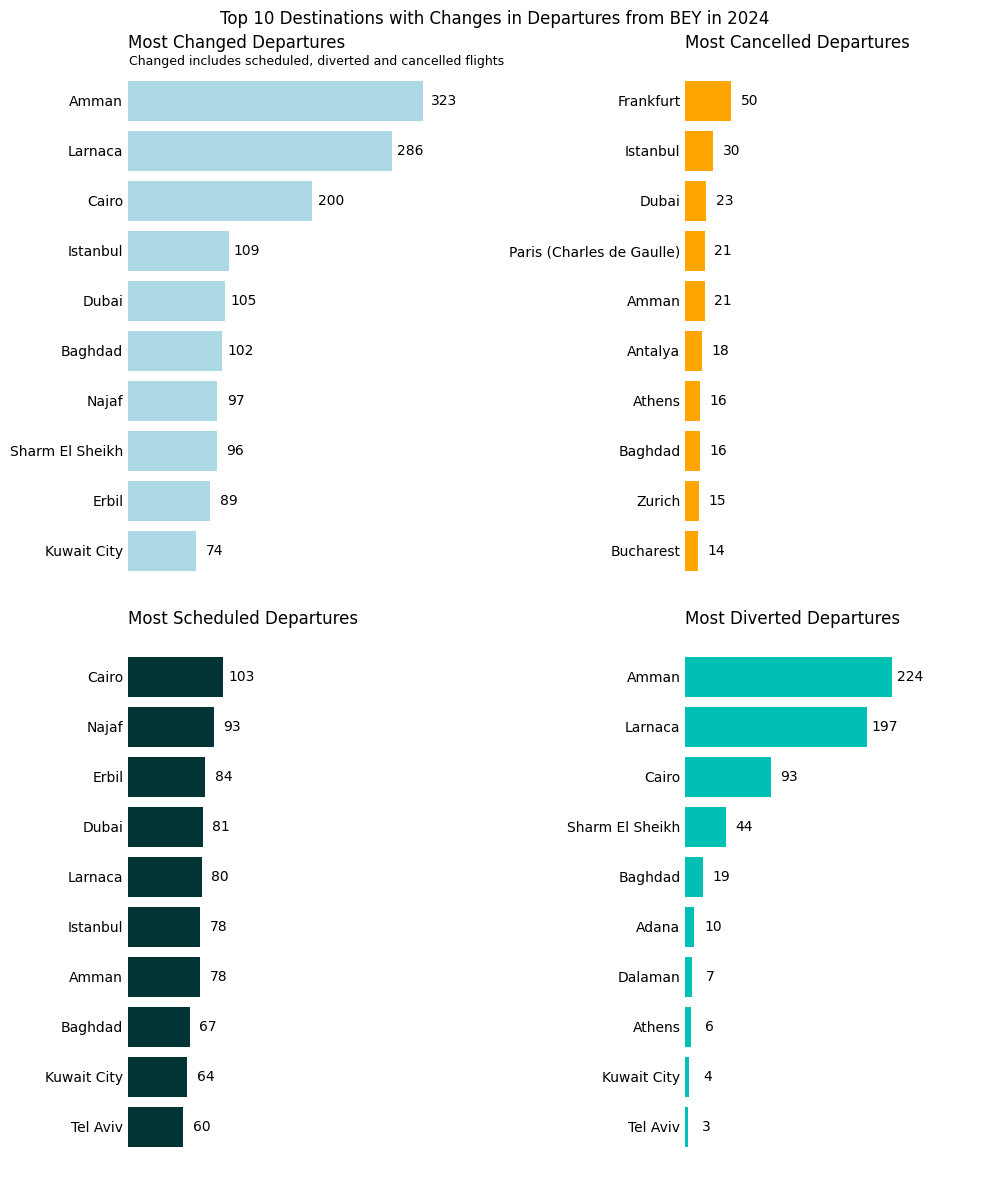

In [127]:
fig, axs = plt.subplots(2,2,figsize=(10,12))
ax = axs.flatten()

ax[0].barh(y='airportcity', width='count', data=most_changed_departures, color='lightblue')
ax[1].barh(y='airportcity', width='count', data=most_cancelled_departures, color='orange')
ax[2].barh(y='airportcity', width='count', data=most_scheduled_departures, color='#023436')
ax[3].barh(y='airportcity', width='count', data=most_diverted_departures, color='#00BFB3')

for a in ax:
    a.set_xlim(0, 320)
    
    # Remove right and top spines
    for spine in a.spines.values():
        spine.set_visible(False)
    
    # Optionally, remove grid lines and ticks (if needed)
    a.xaxis.grid(False)
    a.yaxis.grid(False)
    a.tick_params(axis='both', which='both', length=0)
    a.set_xticks([])  # Remove x-axis ticks

    for index, value in enumerate(a.patches):
        a.text(value.get_width()+20, value.get_y() + value.get_height() / 2, 
                f'{int(value.get_width())}', 
                ha='center', va='center')

# Adding titles and labels (optional)
ax[0].set_title('Most Changed Departures', loc='left')
ax[0].text(0.64, 0.99, 'Changed includes scheduled, diverted and cancelled flights', ha='center', va='center', transform=ax[0].transAxes, fontsize=9)

ax[1].set_title('Most Cancelled Departures', loc='left')
ax[2].set_title('Most Scheduled Departures', loc='left')
ax[3].set_title('Most Diverted Departures', loc='left')

plt.suptitle('Top 10 Destinations with Changes in Departures from BEY in 2024')

plt.subplots_adjust(wspace=0.4) 
plt.tight_layout()



### Findings 

- The airport with the most number of diversions is Amman. Flights to Cairo were scheduled but were either cancelled or diverted. 
- Flights to Frankfurt were cancelled the most. This could be because the Lufthansa group [suspended flight to Lebanon in July](https://www.al-monitor.com/originals/2024/07/lufthansa-cancels-night-flights-lebanon-us-others-issue-travel-warnings).

In [186]:
output_notebook()  # Display plots inline in a Jupyter notebook

departures_exploded['flight_date'] = departures_exploded['flight_date'].apply(lambda x: pd.to_datetime(x))
df = departures_exploded.groupby([pd.Grouper(key='flight_date', freq='W'),'flight_status']).count()[['iata_arr']].reset_index()

show(get_area_plot(df, 'Weekly Departures from BEY', 'Source: Flight data from AviationStack and conflict events from ACLED', acled_events_weekly, reindex_freq='W', events=events))


Loading BokehJS ...

In [128]:
arrivals = pd.concat([pd.read_csv('../../data/aviation/aviationstack_bey_25082024_01012024_arr2.csv'),
                      pd.read_csv('../../data/aviation/aviationstack_bey_26082024_01012024_arr.csv')])
arrivals.drop(columns='Unnamed: 0', inplace=True)
arrivals.drop_duplicates(inplace=True)
arrivals.reset_index(drop=True, inplace=True)

In [130]:
import pandas as pd

df = arrivals
# Assuming df is your DataFrame and 'flight_date' is the column with the dates
df['flight_date'] = pd.to_datetime(df['flight_date'])  # Ensure 'flight_date' is in datetime format

# Generate the complete date range from the minimum to the maximum date
complete_date_range = pd.date_range(start=df['flight_date'].min(), end=df['flight_date'].max())

# Find missing dates by comparing the complete date range with the dates in the DataFrame
missing_dates = complete_date_range.difference(df['flight_date'])

if missing_dates.empty:
    print("All dates are present.")
else:
    print(f"Flights for the following dates are missing in the data, reasons are unknown.: {missing_dates}")


Flights for the following dates are missing in the data, reasons are unknown.: DatetimeIndex(['2024-01-29', '2024-01-30', '2024-04-29', '2024-06-07',
               '2024-06-08', '2024-06-09'],
              dtype='datetime64[ns]', freq=None)


In [131]:
arrivals_exploded = explode(arrivals)

In [132]:
before = arrivals_exploded.shape[0]
print(f'There were {before} flights before duplication check')
# check for duplicate flights i.e., flights scheduled to take off at the exact same time from the same place to the same destination
arrivals_exploded = arrivals_exploded.drop_duplicates(subset=['flight_date', 'scheduled_arr', 'iata_arr', 'iata_dep', 'scheduled_dep'])

after = arrivals_exploded.shape[0]
print(f'There are {after} flights after duplication check. {before-after} flights were duplicated')

There were 28970 flights before duplication check
There are 17221 flights after duplication check. 11749 flights were duplicated


In [133]:
# Test to see if any flight has more than one flight status assoctaed with it.
duplicate_status_test = arrivals_exploded.groupby(['flight_date', 'scheduled_arr', 'iata_arr', 'iata_dep', 'scheduled_dep'])[['flight_status']].count().reset_index()
duplicate_status_test[duplicate_status_test['flight_status']>1]

,flight_date,scheduled_arr,iata_arr,iata_dep,scheduled_dep,flight_status


In [134]:
output_notebook()  # Display plots inline in a Jupyter notebook

df = df = arrivals_exploded.groupby(['flight_date', 'flight_status']).count()[['iata_arr']].reset_index()
df['flight_date'] = df['flight_date'].apply(lambda x: pd.to_datetime(x))

show(get_area_plot(df, 'Daily Arrivals to BEY', 'Source: Flight data from AviationStack and conflict events from ACLED', acled_events_daily, events=events))


Loading BokehJS ...

### Findings

- On 14th April 2024, there was a temporary shutdown on Lebanese airspace between 7AM and 1PM. On that day, there were 15 flights that reported as landed. All the flights in the 'Active' status also donot have an 'actual arrival time' recorded which could lead us to assume that some of them were either cancelled or never took off. 
- There is no flight data on 29th and 30th of January, 29th and 30th of April and 7th to 9th of June 2024. 

In [135]:
output_notebook()  # Display plots inline in a Jupyter notebook

arrivals_exploded['flight_date'] = arrivals_exploded['flight_date'].apply(lambda x: pd.to_datetime(x))
df = arrivals_exploded.groupby([pd.Grouper(key='flight_date', freq='W'),'flight_status']).count()[['iata_arr']].reset_index()

show(get_area_plot(df, 'Weekly Arrivals to BEY', 'Source: Flight data from AviationStack and conflict events from ACLED', acled_events_weekly, reindex_freq='W', events=events))


Loading BokehJS ...

### Findings

- The number of departures than arrivals from the BEY airport
- The number of cancellations, divertions and scheduled flights that were either cancelled or diverted increased since June 2024. 

In [138]:
arrivals_exploded['airportcity'] = arrivals_exploded['iata_dep'].map(iata_mapping)
most_changed_arrivals = pd.DataFrame(arrivals_exploded[arrivals_exploded['flight_status'].isin(['scheduled', 'cancelled', 'diverted'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)
most_cancelled_arrivals = pd.DataFrame(arrivals_exploded[arrivals_exploded['flight_status'].isin(['cancelled'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)
most_scheduled_arrivals = pd.DataFrame(arrivals_exploded[arrivals_exploded['flight_status'].isin(['scheduled'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)
most_diverted_arrivals = pd.DataFrame(arrivals_exploded[arrivals_exploded['flight_status'].isin(['diverted'])]['airportcity'].value_counts().head(10)).reset_index().sort_values(by='count', ascending=True)

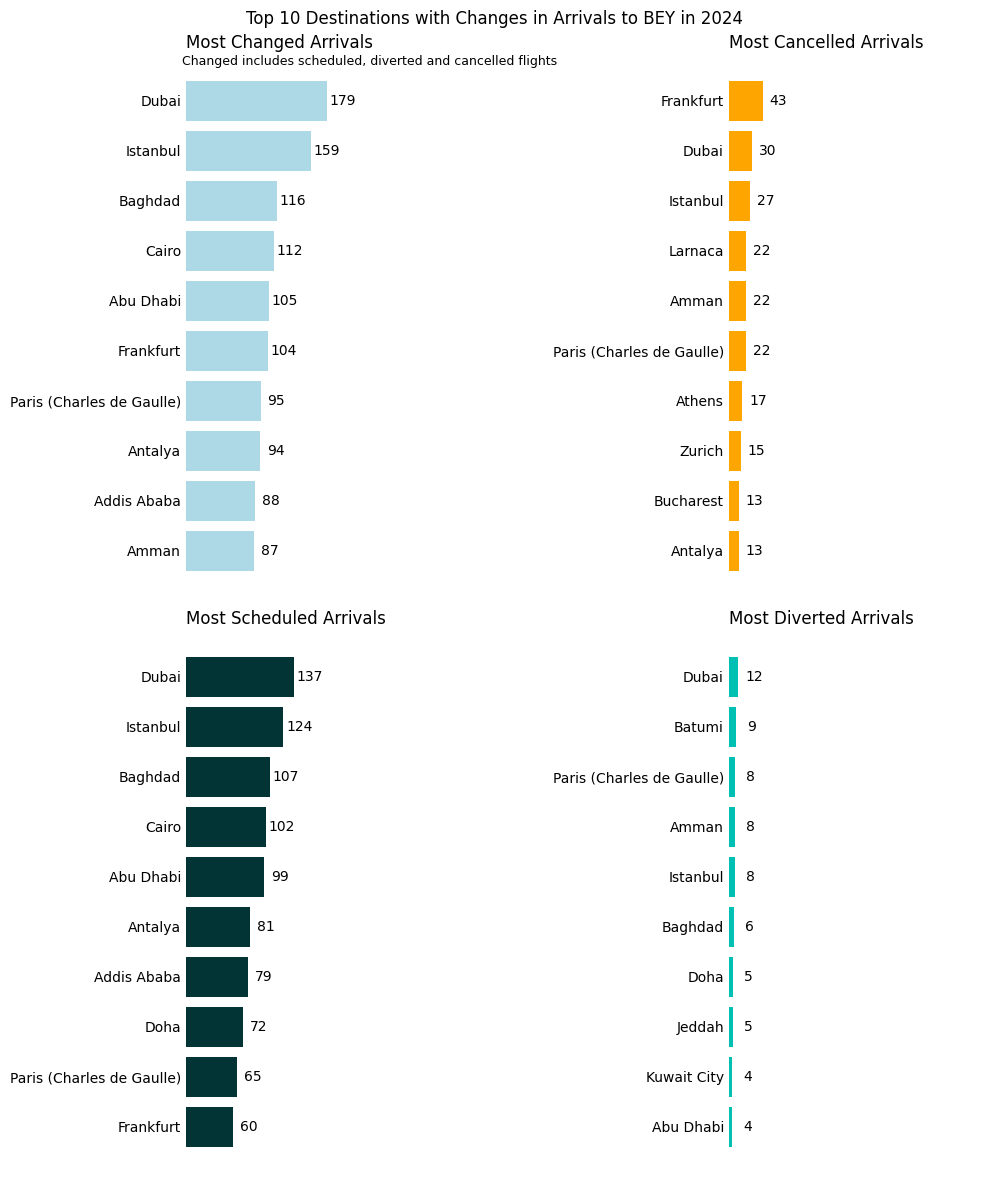

In [142]:
fig, axs = plt.subplots(2,2,figsize=(10,12))
ax = axs.flatten()

ax[0].barh(y='airportcity', width='count', data=most_changed_arrivals, color='lightblue')
ax[1].barh(y='airportcity', width='count', data=most_cancelled_arrivals, color='orange')
ax[2].barh(y='airportcity', width='count', data=most_scheduled_arrivals, color='#023436')
ax[3].barh(y='airportcity', width='count', data=most_diverted_arrivals, color='#00BFB3')

for a in ax:
    a.set_xlim(0, 320)
    
    # Remove right and top spines
    for spine in a.spines.values():
        spine.set_visible(False)
    
    # Optionally, remove grid lines and ticks (if needed)
    a.xaxis.grid(False)
    a.yaxis.grid(False)
    a.tick_params(axis='both', which='both', length=0)
    a.set_xticks([])  # Remove x-axis ticks

    for index, value in enumerate(a.patches):
        a.text(value.get_width()+20, value.get_y() + value.get_height() / 2, 
                f'{int(value.get_width())}', 
                ha='center', va='center')

# Adding titles and labels (optional)
ax[0].set_title('Most Changed Arrivals', loc='left')
ax[0].text(0.73, 0.99, 'Changed includes scheduled, diverted and cancelled flights', ha='center', va='center', transform=ax[0].transAxes, fontsize=9)

ax[1].set_title('Most Cancelled Arrivals', loc='left')
ax[2].set_title('Most Scheduled Arrivals', loc='left')
ax[3].set_title('Most Diverted Arrivals', loc='left')

plt.suptitle('Top 10 Destinations with Changes in Arrivals to BEY in 2024')

plt.subplots_adjust(wspace=0.4) 
plt.tight_layout()



### Findings

- Flights from Frankfurt were also cancelled the most potentially because of Lufthansa. 
- There were far fewer flights from Dubai, potentially because Emirates also [shut down their services to Lebanon temporarily](https://www.reuters.com/world/middle-east/emirates-flydubai-latest-airlines-amend-beirut-flights-2024-07-31/). 